# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import shuffle, seed 

from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from scipy.optimize import minimize
set_config(display="diagram")


### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### See Readme.md file for further analysis and findings. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [14]:
df0 = pd.read_csv( 'data/vehicles.csv' , sep = ',')
df1 = df0.loc[:,[ 'id','price','year','condition','odometer']]
df2 = pd.get_dummies(df1['condition'])

df1 = df1.join(df2)

print(f' df0.isna().sum() \n{ df0.isna().sum() }')
print(f' df0.head()  \n{ df0.head() }')
print(f' df1.head()  \n{ df1.head() }')
print(f' df2.head()  \n{ df2.head() }')

#NOTE remove NaNs from year and odometer columns/features
#NOTE too many nan's in condition ~175K to remove, so keep condition NaNs 
print(f' df1.isna().sum() \n{ df1.isna().sum() }')
df1 = df1.dropna(subset=['year'])
print(f' df1.isna().sum() \n{ df1.isna().sum() }')
df1 = df1.dropna(subset=['odometer'])
print(f' df1.isna().sum() \n{ df1.isna().sum() }')

df1.fillna('unknown', inplace=True)
print(f' df1.isna().sum() \n{ df1.isna().sum() }')
print(f" df1 group by \n{ df1.groupby([ 'condition','excellent' ,'good','fair' ,'like new','new' ,'salvage' ]).size() }")

df1.drop('condition', axis = 1, inplace=True)

# NOTE remove higher pricing and odometer outliers (keep zeros in both features)
print(f' len(df1.index) \n{ len(df1.index) }')
#pri1 = 200000 
#odo1 = 400000 

pri1 = 200000 
odo1 = 400000 
df1 = df1.query(f'price    < {str(pri1)} and odometer < {str(odo1)}')

print(f' len(df1.index) \n{ len(df1.index) }')

print(f' type(df1)   \n{ type(df1)  }')
print(f' df1.head()  \n{ df1.head() }')



 df0.isna().sum() 
id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64
 df0.head()  
           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  N

In [15]:
highest_corr = df1.corr()[['price'
            ]].nlargest(columns = 'price', n = 2).index[1]

print(f'\n\n<*><*>   highest_corr --> { highest_corr }')


#all_indices = list(range(0, len(self._df1)))
all_indices = list(range(0, len(df1)))
seed(42)
shuffle(all_indices)
train_idx, test_idx = np.split(all_indices,[1200])
print(f'all_indices[:5] \n{ all_indices[:5] } ')
print(f'train_idx[:5]   \n{ train_idx[:5] } ')
print(f'test_idx[:5]    \n{ test_idx[:5] } ')


X0 = df1.drop('price', axis = 1)
y0 = df1['price']





<*><*>   highest_corr --> year
all_indices[:5] 
[235744, 337885, 121749, 237763, 276766] 
train_idx[:5]   
[235744 337885 121749 237763 276766] 
test_idx[:5]    
[190399  48559 113833  51895 363386] 


 ols_pipe Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('lin_reg', LinearRegression())]) 


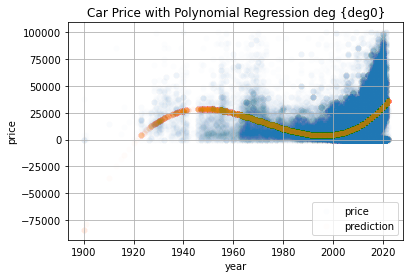

In [30]:
###
### Polynomial Regression 
###

W0 = df1[['year']] 
w0 = df1['year'] 
x0 = df1['odometer'] 
y0 = df1['price'] 

deg0 = 5
plt.clf()
ols_pipe = Pipeline([
        ('poly_features',PolynomialFeatures(degree=deg0,include_bias=False))
        ,('lin_reg',LinearRegression())
        ])
ols_pipe.fit(W0,y0)
ols_preds = ols_pipe.predict(W0)


tit0 = 'Car Price with Polynomial Regression deg {deg0}'
lab0 = 'price'
lab1 = 'prediction'

print(f' ols_pipe { ols_pipe } ')

sns.scatterplot(x=w0,y=y0,          label=lab0,alpha=0.01) 
sns.scatterplot(x=w0,y=ols_preds,   label=lab1,alpha=0.01) 
plt.title(tit0) 
plt.legend()
plt.grid()
plt.show()





x0_len  99999


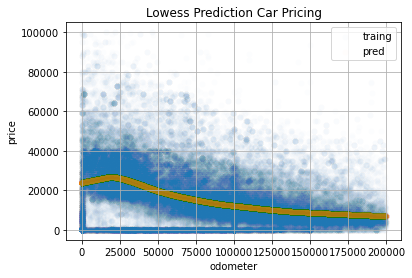

In [26]:



x0 = df1['odometer'][1:100000]
y0 = df1['price'][1:100000] 
x0_len = len(x0)
print(f'x0_len  {x0_len}')


def huber_loss(theta,delta = 1.5):
    ret_val = None 

    #y_pred = theta*X
    #y_err  = np.abs(y-y_pred)
    y_pred = theta*x0
    y_err  = np.abs(y0-y_pred)

    a0 = y_err <=- delta
    a1 = 1/2*(y_err)**2 
    a2 = delta*(y_err -1/2*delta)

    ret_val = sum(np.where(a0,a1,a2))

    return ret_val


lowess = sm.nonparametric.lowess(y0, x0, frac=.3)

# https://stackoverflow.com/questions/36252434/predicting-on-new-data-using-locally-weighted-regression-loess-lowess
# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
        
hl0 = huber_loss(8)
min_theta0 = minimize(huber_loss,x0=0.5)
theta_huber = np.float(min_theta0.x[0])

lab0 = 'traing'
lab1 = 'pred'
tit0 = 'Lowess Prediction Car Pricing'
        
sns.scatterplot(x=x0,y=y0,             label=lab0,alpha=0.01) 
sns.scatterplot(x=lowess_x,y=lowess_y, label=lab1,alpha=0.01) 
plt.legend()
plt.grid()
plt.title(tit0)
plt.show()



### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [17]:

###
###  SFS Sequential Feature Selector
###

sfs0 = SequentialFeatureSelector(
        estimator = LinearRegression()
        ,n_features_to_select = 4
        ,cv = [[train_idx,test_idx]]
        ,scoring = 'neg_mean_squared_error'
        )
Xt0 = sfs0.fit_transform(X0,y0)
print(f' Xt0.shape \n{ Xt0.shape } ')

lin_reg0  = LinearRegression().fit(Xt0,y0)
mod_pred0 = lin_reg0.predict(Xt0)
mse0      = mean_squared_error(y0,mod_pred0)
print(f' SFS Lin Reg MSE: \n{ mse0 } ')

sfs1 = SequentialFeatureSelector(
        estimator = Lasso()
        ,n_features_to_select = 4
        ,cv = [[train_idx,test_idx]]
        ,scoring = 'neg_mean_squared_error'
        )
Xt1 = sfs1.fit_transform(X0,y0)
print(f' Xt1.shape \n{ Xt1.shape } ')

#lin_reg0  = LinearRegression().fit(Xt1,y0)
las_reg1  = Lasso().fit(Xt1,y0)
mod_pred1 = las_reg1.predict(Xt0)
mse1      = mean_squared_error(y0,mod_pred1)
print(f' SFS Lasso MSE: \n{ mse1 } ')





 Xt0.shape 
(395809, 4) 
 SFS Lin Reg MSE: 
169712785.4157395 
 Xt1.shape 
(395809, 4) 
 SFS Lasso MSE: 
169712790.54034293 
 mtj_000 a 0
 X0_train.head() 
                id    year  odometer  excellent  fair  good  like new  new  \
255275  7311911908  2013.0   60812.0          1     0     0         0    0   
364266  7315265839  2017.0   25267.0          0     0     1         0    0   
131815  7314975082  2009.0  136342.0          0     0     0         0    0   
257389  7311522716  2007.0  131020.0          0     0     0         0    0   
298337  7314468733  2003.0  153951.0          1     0     0         0    0   

        salvage  
255275        0  
364266        0  
131815        0  
257389        0  
298337        0   
 y0_train.head() 
255275     7990
364266    20990
131815     7285
257389     6500
298337     5999
Name: price, dtype: int64 
 X0_test.head()  
                id    year  odometer  excellent  fair  good  like new  new  \
205714  7314021595  2010.0  169387.0         

In [22]:

#print(f' X0.head() \n{ X0.head() } ')
#self._mod_pred0 = mod_pred0 

print(' mtj_000 a 0')
#X0_train = self._X0[[train_idx]]
X0_train = df1.iloc[train_idx].drop('price',axis=1)
X0_test  = df1.iloc[test_idx].drop('price',axis=1)
y0_train = df1.iloc[train_idx]['price']
y0_test  = df1.iloc[test_idx]['price']
#X0_test = self._X0[test_idx]
print(f' X0_train.head() \n{ X0_train.head() } ')
print(f' y0_train.head() \n{ y0_train.head() } ')
print(f' X0_test.head()  \n{ X0_test.head() } ')
print(f' y0_test.head()  \n{ y0_test.head() } ')
print(f' mtj_000 a 1')

print(f' X0_train.shape \n{ X0_train.shape } ')
print(f' X0_test.shape  \n{ X0_test.shape } ')
print(f' mtj_000 a 2')
print(f' y0_train.shape \n{ y0_train.shape } ')
print(f' y0_test.shape  \n{ y0_test.shape } ')
print(f' mod_pred0.shape \n{ mod_pred0.shape } ')
print(f' mtj_000 a 3')


 mtj_000 a 0
 X0_train.head() 
                id    year  odometer  excellent  fair  good  like new  new  \
255275  7311911908  2013.0   60812.0          1     0     0         0    0   
364266  7315265839  2017.0   25267.0          0     0     1         0    0   
131815  7314975082  2009.0  136342.0          0     0     0         0    0   
257389  7311522716  2007.0  131020.0          0     0     0         0    0   
298337  7314468733  2003.0  153951.0          1     0     0         0    0   

        salvage  
255275        0  
364266        0  
131815        0  
257389        0  
298337        0   
 y0_train.head() 
255275     7990
364266    20990
131815     7285
257389     6500
298337     5999
Name: price, dtype: int64 
 X0_test.head()  
                id    year  odometer  excellent  fair  good  like new  new  \
205714  7314021595  2010.0  169387.0          0     0     0         0    0   
52807   7316190893  2011.0   62711.0          0     0     0         0    0   
123406  731483

 typ0  
<class 'numpy.ndarray'> 
 typ1  
<class 'pandas.core.series.Series'> 
 ridge_train_mse   
149902435.57482034 
 ridge_test_mse    
170893376.48970547 


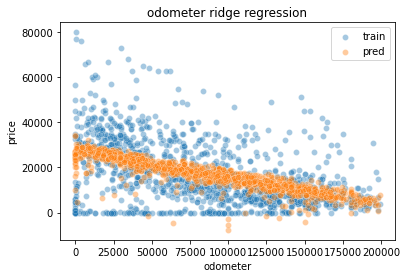

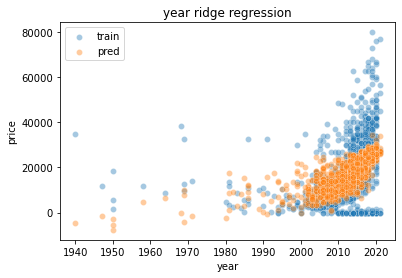

In [23]:


###
### Ridge
###

ridge_param_dict = { 'ridge__alpha': np.logspace(0,10,50) }
ridge_pipe  = Pipeline([ 
         ('scalar',StandardScaler())
        ,('ridge',Ridge()) 
        ])
ridge_grid = GridSearchCV(ridge_pipe,param_grid=ridge_param_dict)
ridge_grid.fit(X0_train,y0_train)
ridge_train_preds = ridge_grid.predict(X0_train)
ridge_test_preds  = ridge_grid.predict(X0_test)
typ0 = type(ridge_train_preds)
typ1 = type(y0_train)
            
print(f' typ0  \n{ typ0 } ')
print(f' typ1  \n{ typ1 } ')
ridge_train_mse   = mean_squared_error(y0_train,ridge_train_preds)
ridge_test_mse    = mean_squared_error(y0_test ,ridge_test_preds)
print(f' ridge_train_mse   \n{ ridge_train_mse   } ')
print(f' ridge_test_mse    \n{ ridge_test_mse    } ')

tit0 = 'odometer ridge regression'
lab0 = 'train'
lab1 = 'test'
lab2 = 'pred'
fig0, ax0 = plt.subplots()
ax0.ticklabel_format(style='plain')
#sns.scatterplot(x0,y0,c=c0,    label=lab0,alpha=0.01) 
x0 = X0_train['odometer']
sns.scatterplot(x=x0,y=y0,   label=lab0,alpha=0.4) 
sns.scatterplot(x=x0,y=ridge_train_preds,   label=lab2,alpha=0.4) 

plt.title(tit0) 
plt.legend() 
plt.show() 



tit0 = 'year ridge regression'
lab0 = 'train'
lab1 = 'test'
lab2 = 'pred'
fig0, ax0 = plt.subplots()
ax0.ticklabel_format(style='plain')
x0 = X0_train['year']
sns.scatterplot(x=x0,y=y0,   label=lab0,alpha=0.4) 
sns.scatterplot(x=x0,y=ridge_train_preds,   label=lab2,alpha=0.4) 
plt.title(tit0) 
plt.legend() 
plt.show() 



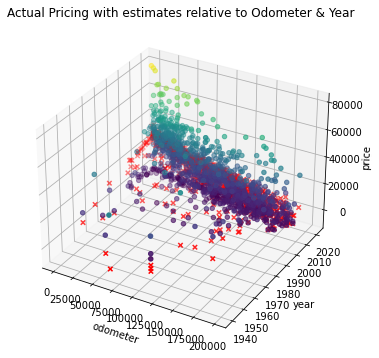

In [31]:

### 
### 3D scatter plot 
### 

a0 = X0_train['odometer']
a1 = X0_train['year']
a2 = y0_train
a3 = ridge_train_preds  
lab0 = 'price'
lab1 = 'pred'
tit0 = 'Actual Pricing with estimates relative to Odometer & Year'

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a0, a1, a2, c=a2, cmap='viridis', marker='o',label=lab0)
ax.scatter(a0, a1, a3, c='red', cmap='viridis', marker='x',label=lab1)
ax.set_xlabel('odometer')
ax.set_ylabel('year')
ax.set_zlabel('price')
plt.title(tit0) 
plt.show()



### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Report

See Readme.md for the report. 